# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_m\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_n\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $S = (d^{\frac{1}{p}}) / n$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Lap}(2 * S / \epsilon)$, where $\epsilon$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(X, \tilde{Y}) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import sys
print(sys.version)
import argparse
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pdb
import sys
import time
import tensorflow as tf
print(tf.__version__)
from scipy.stats import ks_2samp, truncnorm
from scipy.spatial.distance import pdist, squareform

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


In [67]:
def get_support_points(x, num_support, max_iter=1000, lr=1e-2, is_tf=False):
    # Initialize generated particles for both sets (y and y_).
    d = x.shape[1]
    offset = 0.1

    if Y_INIT_OPTION == 'grid':
        grid_size = int(np.sqrt(num_support))
        assert grid_size == np.sqrt(num_support), 'num_support must square for grid'
        _grid = np.linspace(offset, 1 - offset, grid_size)
        y = np.array(np.meshgrid(_grid, _grid)).T.reshape(-1, d)
        # Perturb grid in order to give more diverse gradients.
        y += np.random.normal(0, 0.005, size=y.shape)

    elif Y_INIT_OPTION == 'random':
        y = np.random.uniform(offset, 1 - offset, size=(num_support, d))
    
    # Optimize particles for each dataset (x0 and x1).
    y_out, e_out = optimize_support_points(x, y, max_iter=max_iter, learning_rate=lr,
                                           is_tf=is_tf)
    
    # Get last updated set as support points.
    sp = y_out[-1]
    
    return sp, e_out

In [70]:
def optimize_support_points(data, gen, max_iter=500, learning_rate=1e-2, is_tf=False):
    """Runs TensorFlow optimization, n times through proposal points.
    Args:
      data: ND numpy array of any length, e.g. (100, dim).
      gen: ND numpy array of any length, e.g. (10, dim).
      max_iter: Scalar, number of times to loop through updates for all vars.
      learning_rate: Scalar, amount to move point with each gradient update.
      is_tf: Boolean. Chooses TensorFlow optimization.
      
    Returns:
      y_out: (max_iter,N,D)-array. Trace of generated proposal points.
      e_out: Float, energy between data and last iteration of y_out.
    """
    
    if is_tf:
        print('\n  [*] Using TensorFlow optimization.')
        y_out = np.zeros((max_iter, gen.shape[0], gen.shape[1]))

        # Build TensorFlow graph.
        tf.reset_default_graph()
        tf_input_data = tf.placeholder(tf.float32, [None, data.shape[1]], name='input_data')
        tf_candidate_sp = tf.Variable(gen, name='sp', dtype=tf.float32)
        tf_e_out, _ = energy(tf_input_data, tf_candidate_sp, power=ENERGY_POWER, is_tf=True)

        #tf_optim = tf.train.AdamOptimizer(learning_rate).minimize(tf_e_out)
        #opt = tf.train.AdamOptimizer(learning_rate)
        #opt = tf.train.RMSPropOptimizer(learning_rate)
        opt = tf.train.GradientDescentOptimizer(learning_rate)
        tf_grads, tf_variables = zip(*opt.compute_gradients(tf_e_out))
        tf_optim = opt.apply_gradients(zip(tf_grads, tf_variables))
        

        # Initialize graph.
        tf_init_op = tf.global_variables_initializer()
        tf_gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
        tf_sess_config = tf.ConfigProto(allow_soft_placement=True, gpu_options=tf_gpu_options)

        # Run training.
        with tf.Session(config=tf_sess_config) as sess:
            sess.run(tf_init_op)

            start_time = time.time()
            
            for it in range(max_iter):
                data_, sp_, e_, e_grads_, e_vars_ = sess.run(
                    [tf_input_data, tf_candidate_sp, tf_e_out, tf_grads, tf_variables],
                    {tf_input_data: data})

                batch_size = int(M / 10)
                batch_data = data[np.random.choice(len(data), batch_size)]
                sess.run([tf_optim], {tf_input_data: batch_data})
                #sess.run([tf_optim], {tf_input_data: data})

                
                # ------------------------------------------------------------------
                # TODO: Decide whether to clip support points to domain bounds.
                sp_ = np.clip(sp_, 0, 1)
                # ------------------------------------------------------------------

                
                # Store result in container.
                y_out[it, :] = sp_

                # Plot occasionally.
                if data.shape[1] == 2 and it in SAVE_ITER and it > 0:
                    if it > 0:
                        print('  [*] Overall it/s: {:.4f}'.format((time.time() - start_time) / it))
                    plt.scatter(data[:,0], data[:,1], c='black', s=64, alpha=0.3, label='data')
                    plt.scatter(sp_[:,0], sp_[:,1], s=32, c='limegreen', label='sp')
                    
                    # Plot arrows of gradients at each point.
                    for i, sp in enumerate(sp_):
                        plt.arrow(sp[0], sp[1], *(-1. * e_grads_[0][i]),
                                  color='white', edgecolor='white',
                                  head_width=0.02, head_length=0.02,
                                  length_includes_head=False)
                    
                    plt.title('it: {}, e_out: {:.8f}'.format(it, e_))
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.axis('equal')
                    plt.show()
    
    else:
        print('\n  [*] Using analytical gradient optimization.')
        y_out = np.zeros((max_iter, gen.shape[0], gen.shape[1]))
    
        # Run optimization steps.
        for it in range(max_iter):
            e_, e_grads = energy(data, gen, power=ENERGY_POWER)
            gen -= learning_rate * e_grads

            
            # ------------------------------------------------------------------
            # TODO: Decide whether to clip support points to domain bounds.
            gen = np.clip(gen, 0, 1)
            # ------------------------------------------------------------------
            
            y_out[it, :] = gen

            
            
            # Plot occasionally.
            if data.shape[1] == 2 and it in SAVE_ITER and it > 0:
                plt.scatter(data[:,0], data[:,1], c='black', s=64, alpha=0.3, label='data')
                plt.scatter(gen[:,0], gen[:,1], s=32, c='limegreen', label='sp')
                
                # Plot arrows of gradients at each point.
                for i, sp in enumerate(gen):
                    plt.arrow(sp[0], sp[1], *(-1. * e_grads[i]),
                              color='white', edgecolor='white',
                              head_width=0.02, head_length=0.02,
                              length_includes_head=False)
                
                plt.title('it: {}, e_out: {:.8f}'.format(it, e_))
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                plt.axis('equal')
                plt.show()
    
    return y_out, e_

In [36]:
def energy(data, gen, sigma=1., power=1., is_tf=False):
    """Computes abbreviated energy statistic between two point sets.

    The smaller the value, the closer the sets.
    Args:
      data: ND numpy array of any length, e.g. (1000, 2).
      gen: ND numpy array of any length, e.g. (10, 2).
      sigma: Float, kernel lengthscale.
      power: Exponent in distance metric. Must be >= 1.
      is_tf: Boolean. Selects for TensorFlow functions.
    Returns:
      e: Scalar, the energy between the sets.
      mmd: Scalar, the mmd between the sets.
      gradients_e: Numpy array of energy gradients for each proposal point.
    """
    assert power >= 1, 'Power must be >= 1.'
    
    
    # ------------- NumPy VERSION -------------
    
    if not is_tf:
        x = data
        y = gen
        dim = x.shape[1]
        data_num = len(x)
        gen_num = len(y)
        
        # Compute energy.
        v = np.concatenate((x, y), 0)
        v_tiled_across = np.tile(v[:, np.newaxis, :], (1, v.shape[0], 1))
        v_tiled_down = np.tile(v[np.newaxis, :, :], (v.shape[0], 1, 1))
        pairwise_difs = v_tiled_across - v_tiled_down
        energy = np.linalg.norm(pairwise_difs, axis=2, ord=power)
        
        energy_xx = energy[:data_num, :data_num]
        energy_yy = energy[data_num:, data_num:]
        energy_xy = energy[:data_num, data_num:]
                
        energy_xx_upper = np.triu(energy_xx)
        energy_yy_upper = np.triu(energy_yy)
        
        num_combos_x = data_num * (data_num - 1) / 2
        num_combos_y = gen_num * (gen_num - 1) / 2
        num_combos_xy = data_num * gen_num

        e = (2. / gen_num / data_num * np.sum(energy_xy) -
             1. / data_num / data_num * np.sum(energy_xx) -
             1. / gen_num / gen_num * np.sum(energy_yy))
        #e = (2. / num_combos_xy * np.sum(energy_xy) -
        #     1. / num_combos_x * np.sum(energy_xx_upper) -
        #     1. / num_combos_y * np.sum(energy_yy_upper))

    
        # Compute energy gradients.    
        # Note: Term2 assumes y in first position. For y in second position,
        #       need to multiply grad_matrix by -1.
        if power == 1:
            term1 = np.sign(np.sum(pairwise_difs, axis=2))
            term2 = np.sign(pairwise_difs)
        else:
            c1 = 1. / power
            
            # Define term containing Infs on diag, then replace Infs w/ zero.
            term1 = c1 * np.sum(pairwise_difs ** power, axis=2) ** (c1 - 1)
            #np.fill_diagonal(term1, 0)
            term1[np.where(term1 == np.inf)] = 0

            term2 = power * (pairwise_difs ** (power - 1))
            
            
        assert len(term1[:,:,np.newaxis].shape) == len(term2.shape)
        grad_matrix = term1[:, :, np.newaxis] * term2
        grad_matrix_yx = grad_matrix[data_num:, :data_num]
        grad_matrix_yy = grad_matrix[data_num:, data_num:]

        gradients_e = np.zeros((gen_num, dim))
        for i in range(gen_num):
            grad_yi = (2. / data_num / gen_num * np.sum(grad_matrix_yx[i], axis=0) -
                       2. / gen_num / gen_num * np.sum(grad_matrix_yy[i], axis=0))
            gradients_e[i] = grad_yi
        
    
    # ------------- TensorFlow VERSION -------------
    
    elif is_tf:
        x = data
        y = gen
        dim = tf.shape(x)[1]
        data_num = tf.shape(x)[0]
        gen_num = tf.shape(y)[0]

        # Compute energy.
        v = tf.concat([x, y], 0)
        v_tiled_across = tf.tile(tf.expand_dims(v, 1), [1, tf.shape(v)[0], 1])
        v_tiled_down = tf.tile(tf.expand_dims(v, 0), [tf.shape(v)[0], 1, 1])
        pairwise_difs = v_tiled_across - v_tiled_down
        
        # Replace diagonals (which are Infs) with zeros.
        diag_filler = 1e-10 * tf.eye(tf.shape(pairwise_difs)[0])
        diag_filler = tf.tile(
            tf.expand_dims(diag_filler, 2),
            [1, 1, tf.shape(pairwise_difs)[2]])
        pairwise_difs = pairwise_difs + diag_filler
        
        # Define energy over pairwise difs.
        energy = tf.norm(pairwise_difs, axis=2, ord=power)
        
        energy_xx = energy[:data_num, :data_num]
        energy_yy = energy[data_num:, data_num:]
        energy_xy = energy[:data_num, data_num:]

        energy_xx_upper = tf.matrix_band_part(energy_xx, 0, -1)
        energy_yy_upper = tf.matrix_band_part(energy_yy, 0, -1)
        
        m = tf.cast(data_num, tf.float32)
        n = tf.cast(gen_num, tf.float32)
        #num_combos_x = tf.cast(data_num * (data_num - 1) / 2, tf.float32)
        #num_combos_y = tf.cast(gen_num * (gen_num - 1) / 2, tf.float32)
        #num_combos_xy = tf.cast(data_num * gen_num, tf.float32)
        
        e = (2. / n / m * tf.reduce_sum(energy_xy) -
             1. / m / m * tf.reduce_sum(energy_xx) -
             1. / n / n * tf.reduce_sum(energy_yy))
        #e = (2. / num_combos_xy * tf.reduce_sum(energy_xy) -
        #     1. / num_combos_x * tf.reduce_sum(energy_xx_upper) -
        #     1. / num_combos_y * tf.reduce_sum(energy_yy_upper))
        
        gradients_e = None

    return e, gradients_e


____

# 1. Global Config

In [31]:
# Set global constants.   # main()
IS_TF = True              # Boolean. Use TensorFlow rather than analytical gradients.
ENERGY_POWER = 2          # [2., 1.]
Y_INIT_OPTION = 'random'    # ['grid', 'random']
DATA_SOURCE = 'balog'     # ['balog', 'gaussian', 'gamma', 'laplace', 'beta']
MAX_ITER = 301            # Num iterations in each support point optimization. [301]
SAVE_ITER = 300           # How often to plot results during training. [100]
LR = 0.01                 # Energy optimization learning rate. [1e-2]
DIFFUSION_SIZE = 1e-2     # Scale of noise diffusion in ExpMech step.
EPS = 1                   # Differential privacy level.
M = 200                  # Number of data points.
N = 25                    # Number of support points.
DIM = 2                   # Dimension of data.

___

# 2. Load and Plot Data

In [6]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=200 data points with dimension DIM=2


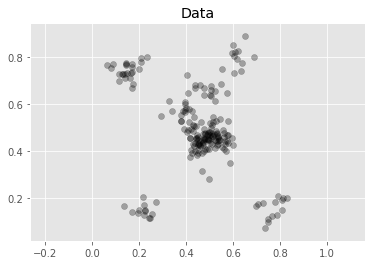

In [7]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:,0], x[:,1], c="black", alpha=0.3);
    plt.title('Data');
    plt.axis('equal')
    plt.show()
elif DATA_SOURCE == 'gaussian':
    M = 1000
    a, b = -3, 3
    x = truncnorm.rvs(a, b, size=M)
    x = np.sort(x)
    diam_x = b - a
elif DATA_SOURCE == 'beta':
    M = 1000
    a, b = 2, 2
    x = np.random.beta(a, b, size=M)
    x = np.sort(x)
    diam_x = 1.
else:
    print('Set up fn for unknown data_source')
    sys.exit()

___

# 3. Run Support Point Optimization


  [*] Using TensorFlow optimization.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0081


/Users/mauricediesendruck/venv/lib/python3.7/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


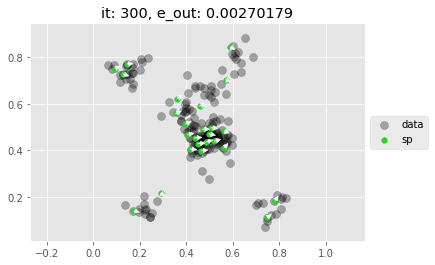

In [8]:
# Compute m support points on full set.
y, e_out = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Sample Using Exponential Mechanism

In [9]:
def sample_sp_exp_mech(e_out, energy_sensitivity, x, y, max_iter, lr, eps=1.):        
    # Sample energy distance.
    # TODO: Must be {larger than optimal energy distance, positive}.
    e_tilde = -1
    while e_tilde < 0:
        e_tilde = np.random.laplace(scale=2. * energy_sensitivity / eps)
    
    # Sample support points:
    
    # ---------- ALGORITHM 1: DIFFUSE FROM OPTIMAL ----------
    
    # Start with copy of optimal support points, then diffuse until 
    # energy(true, copy) is at least e_tilde.
    y_tilde = y.copy()
    energy_y_y_tilde = 0.
    count = 0
    max_count = 1e3
    while energy_y_y_tilde < e_tilde and count < max_count:
        y_tilde += np.random.normal(0, DIFFUSION_SIZE, size=y_tilde.shape)

        energy_y_y_tilde, _ = energy(y, y_tilde)

        count += 1
    
    if count < max_count:
        print(('Diffusion count {:5}, e_out: {:9.8f}, e~: {:6.3f}, '
               'energy(y,y~): {:5.3f}, error%: {:.3f}').format(
            count, e_out, e_tilde, energy_y_y_tilde, (energy_y_y_tilde - e_tilde) / e_tilde))
    else:
        print('DID NOT REACH E-TILDE LEVEL')
        sys.exit()
        
    # -------------------------------------------------------
        
    return y_tilde, e_tilde, energy_y_y_tilde

In [10]:
# Define energy sensitivity for Exponential Mechanism.

#EPS = 1
#DIFFUSION_SIZE = 1e-2

#energy_sensitivity = np.power(dim, 1. / ENERGY_POWER) / N
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2  # TODO: New result, verify

print('Laplace(2 * S / eps) = Laplace(2 * {:.4f} / {:.2f}) = Laplace({:.3f})'.format(
    energy_sensitivity, EPS, 2. * energy_sensitivity / EPS))

Laplace(2 * S / eps) = Laplace(2 * 0.0045 / 1.00) = Laplace(0.009)


In [11]:
# Sample support points.
y_tildes_info = []
num_y_tildes = 5

for i in range(num_y_tildes):
    y_tilde, e_tilde, energy_x_y_tilde = sample_sp_exp_mech(
        e_out, energy_sensitivity, x, y, MAX_ITER, LR, eps=EPS)
    y_tildes_info.append({'y_tilde': y_tilde,
                          'e_out': e_out,
                          'e_tilde': e_tilde,
                          'energy_x_y_tilde': energy_x_y_tilde})

Diffusion count     3, e_out: 0.00270179, e~:  0.002, energy(y,y~): 0.003, error%: 0.424
Diffusion count     9, e_out: 0.00270179, e~:  0.003, energy(y,y~): 0.004, error%: 0.196
Diffusion count     5, e_out: 0.00270179, e~:  0.003, energy(y,y~): 0.003, error%: 0.227
Diffusion count     2, e_out: 0.00270179, e~:  0.001, energy(y,y~): 0.002, error%: 0.371
Diffusion count    63, e_out: 0.00270179, e~:  0.015, energy(y,y~): 0.016, error%: 0.011


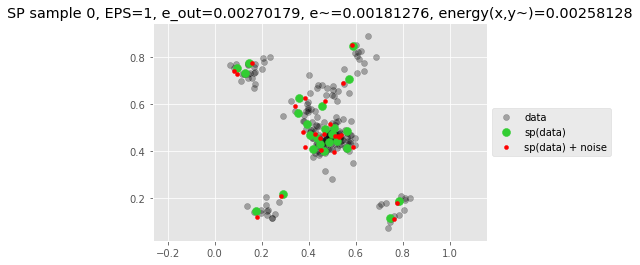

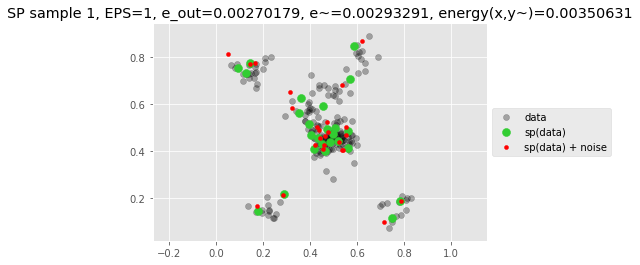

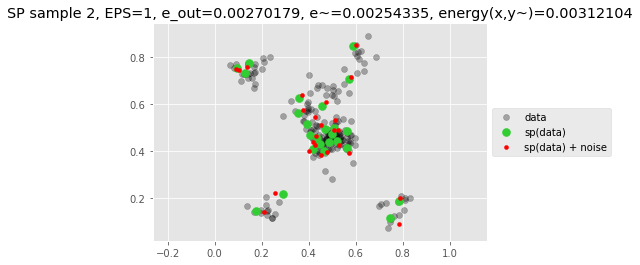

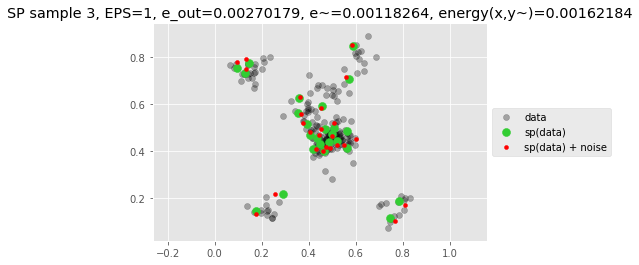

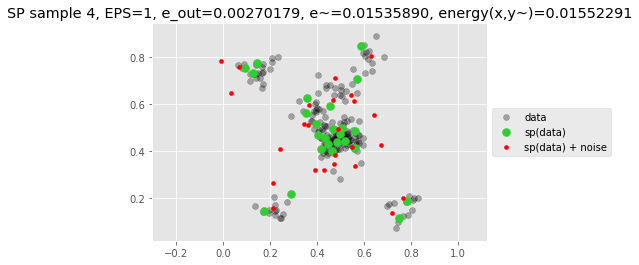

In [12]:
# Plot results.
for i, info in enumerate(y_tildes_info):
    plt.scatter(x[:, 0], x[:, 1], c='black', label='data',
                alpha=0.3)
    plt.scatter(y[:, 0], y[:, 1], c='limegreen', label='sp(data)', s=64)
    plt.scatter(info['y_tilde'][:, 0], 
                info['y_tilde'][:, 1],
                c='red', label='sp(data) + noise', s=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('SP sample {}, EPS={}, e_out={:.8f}, e~={:.8f}, energy(x,y~)={:.8f}'.format(
        i, EPS, info['e_out'], info['e_tilde'], info['energy_x_y_tilde']))
    plt.axis('equal')
    plt.show()

___

# End.

___

___

___

# Show that min/max occur at extrema for all data configurations.

/Users/mauricediesendruck/venv/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in power


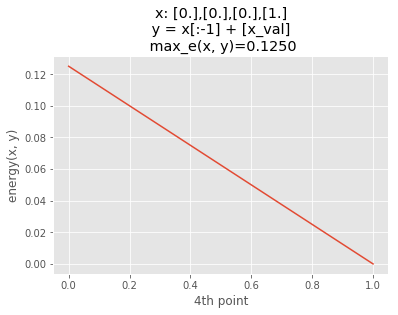

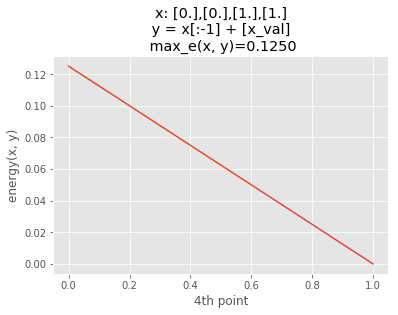

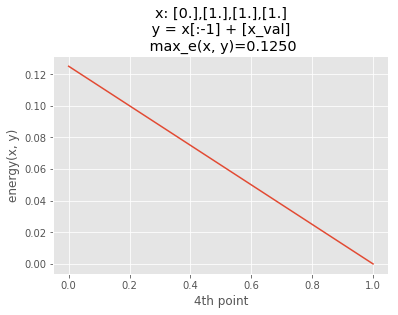

In [13]:
# main2()
N = 4
DIM = 1
GRID_SIZE = 10
ENERGY_POWER = 2

for i in range(1, int(N / 2) + 2):  # Only need to show half the range, because it is symmetric.
    n_one = i
    n_zero = N - n_one
    x = np.concatenate((np.zeros((n_zero, DIM)), np.ones((n_one, DIM))))

    energies = []
        
    for j in np.linspace(0, 1, GRID_SIZE):
        if DIM == 1:
            y = np.concatenate((x[:-1], np.array([[j]])), axis=0)        
        elif DIM == 2:
            y = np.concatenate((x[:-1], np.array([[j, j]])), axis=0)        

        e_, _ = energy(x, y, power=ENERGY_POWER)

        energies.append(e_)
    
    plt.plot(np.linspace(0, 1, GRID_SIZE), energies)
    if DIM == 1:
        plt.title('x: {}\n y = x[:-1] + [x_val] \n max_e(x, y)={:.4f}'.format(
            ','.join([str(k) for k in x]), max(energies)))
    elif DIM == 2:
        plt.title('x: {}\n y = x[:-1] + [x_val, x_val] \n max_e(x, y)={:.4f}'.format(
            ','.join([str(k) for k in x]), max(energies)))
    plt.xlabel('{}th point'.format(N))
    plt.ylabel('energy(x, y)')
    plt.show()
    
    


# Show "extrema-seeking" behavior of SP, and measure Energy Sensitivity (on data and on SP).

x: 10 zeros, 0 ones

  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0016


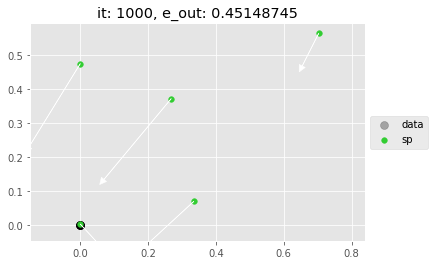

  [*] Overall it/s: 0.0017


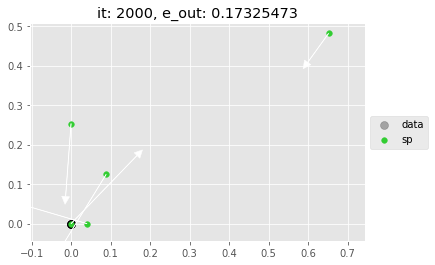

In [ ]:
#main3()
M = 10  # Data size.
N = 5   # Support size.
DIM = 2
ENERGY_POWER = 2
LR = 1e-3
MAX_ITER = 40001
SAVE_ITER = [1000, 2000, 20000, 40000]

data_sets = []
sp_sets = []
energies_data = []
energies_sp = []

# Create all extreme configurations of points.
for i in range(M):
#for i in [4]:
    n_one = i
    n_zero = M - n_one
    print('x: {} zeros, {} ones'.format(n_zero, n_one))
    
    x = np.concatenate((np.zeros((n_zero, DIM)), np.ones((n_one, DIM))))
    sp_x, _ = get_support_points(x, N, lr=LR, max_iter=MAX_ITER, is_tf=True)

    data_sets.append(x)
    sp_sets.append(sp_x)

# Measure pairwise energy distances between support point sets.
energies_between_sp_sets = []
for i in range(1, len(sp_sets)):
    e_adj_sps, _ = energy(sp_sets[i], sp_sets[i - 1], power=ENERGY_POWER)
    energies_between_sp_sets.append(e_adj_sps)

print('Energies between support point sets (ordered, pairwise):')
print(np.round(energies_between_sp_sets, 4),
      np.argmax(energies_between_sp_sets),
      energies_between_sp_sets[np.argmax(energies_between_sp_sets)])
print(('Analytical result max change \n  = 2 * d^(1/p) / num_support^2\n  = '
       '2 * {}^(1/{}) / {}^2\n  = {}').format(DIM, ENERGY_POWER, N,
                                              2 * DIM ** (1 / ENERGY_POWER) / N ** 2))